In [1]:
import os
import numpy as np 
import math
import pandas as pd 
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, SimpleRNN
#"/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/data.csv"
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
plt.style.use('fivethirtyeight')

In [2]:
# salmon_data = pd.read_csv(r"/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/data.csv")
# salmon_data.head()
# salmon_copy = salmon_data # Create a copy for us to work with 
def load_data(pathname):
    salmon_data = pd.read_csv(pathname)
    salmon_data.head()
    salmon_copy = salmon_data # Create a copy for us to work with 
    salmon_copy.rename(columns = {"mo": "month", "da" : "day", "fc" : "king"}, 
          inplace = True)
    salmon_copy['date']=pd.to_datetime(salmon_copy[['year','month','day']])
#     print(salmon_copy)
    king_data = salmon_copy.filter(["date","king"], axis=1)
    print(king_data)
    king_greater = king_data['date'].apply(pd.Timestamp) >= pd.Timestamp('01/01/1939')
    greater_than = king_data[king_greater]
    king_all = greater_than[greater_than['date'].apply(pd.Timestamp) <= pd.Timestamp('12/31/2020')]
    king_all_copy = king_all
    king_all_copy = king_all_copy.reset_index()
    king_all_copy = king_all_copy.drop('index', axis=1)
    return king_all_copy, king_data

In [5]:
    chris_path = '/Users/chrisshell/Desktop/Stanford/SalmonData/Use Data/passBonCS.csv'
    ismael_path = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/data.csv'
    abdul_path = ''
    king_all_copy, king_data= load_data(chris_path)
    print(king_all_copy)

            date  king
0     1938-05-01   201
1     1938-05-02   227
2     1938-05-03    78
3     1938-05-04    37
4     1938-05-05    29
...          ...   ...
24729 2021-04-28  2433
24730 2021-04-29  4782
24731 2021-04-30  4641
24732 2021-05-01  2087
24733 2021-05-02  2517

[24734 rows x 2 columns]
            date  king
0     1939-01-01     0
1     1939-01-02     0
2     1939-01-03     0
3     1939-01-04     1
4     1939-01-05     0
...          ...   ...
24364 2020-12-25     0
24365 2020-12-26     0
24366 2020-12-27     0
24367 2020-12-28     0
24368 2020-12-29     0

[24369 rows x 2 columns]


In [52]:
def create_train_test(king_all):
    king_training_parse = king_all['date'].apply(pd.Timestamp) <= pd.Timestamp('12/31/2015')
    king_training = king_all[king_training_parse]
    king_training = king_training.reset_index()
    king_training = king_training.drop('index', axis=1)
    
    king_test_parse = king_all['date'].apply(pd.Timestamp) > pd.Timestamp('12/31/2015')
    king_test = king_all[king_test_parse]
    king_test = king_test.reset_index()
    king_test = king_test.drop('index', axis=1)
    print(king_test.shape)
    
    # Normalizing Data
    king_training[king_training["king"] < 0] = 0 
    king_test[king_test["king"] < 0] = 0
    king_train_pre = king_training["king"].to_frame()
    king_test_pre = king_test["king"].to_frame()
    scaler = MinMaxScaler(feature_range=(0, 1))
    king_train_norm = scaler.fit_transform(king_train_pre)
    king_test_norm = scaler.fit_transform(king_test_pre)
    print(king_test_norm.shape)
    #king_train_norm = (king_training["king"] - np.min(king_training["king"])) / (np.max(king_training["king"]) - np.min(king_training["king"]))
    #print(type(king_train_norm))
    #king_train_norm = king_train_norm.to_frame()
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    
    # Todo: Experiment with input size of input (ex. 30 days)
    
    for i in range(180,22545): # 30
        x_train.append(king_train_norm[i-180:i])
        y_train.append(king_train_norm[i])
    for i in range(180, 1824):
        x_test.append(king_test_norm[i-180:i])
        y_test.append(king_test_norm[i])
        
    return x_train, y_train, x_test, y_test, scaler

In [53]:
x_train, y_train, x_test, y_test, scaler = create_train_test(king_all_copy)
x_train = np.array(x_train)
x_test = np.array(x_test)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1)).astype(np.float32)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
y_train = np.array(y_train)
y_test = np.array(y_test)
print(y_test.shape)

(1824, 2)
(1824, 1)
(1644, 1)


In [77]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real Chinook Count')
    plt.plot(predicted, color='blue',label='Predicted Chinook Count')
    plt.title('Chinook Population Prediction')
    plt.xlabel('Time')
    plt.ylabel('Chinook Count')
    plt.legend()
    plt.show()

def return_rmse(test, predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [9]:
def create_single_layer_rnn_model(x_train, y_train, x_test, scaler, king_training):
    '''
    create single layer rnn model trained on x_train and y_train
    and make predictions on the x_test data
    '''
    # create a model
    model = Sequential()
    model.add(SimpleRNN(32))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')

    # fit the RNN model
    history = model.fit(x_train, y_train, epochs=10, batch_size=64)

    print("predicting")
    # Finalizing predictions
    RNN_train_preds = model.predict(x_train)
    RNN_test_preds = model.predict(x_test)
    
    #Descale
    RNN_train_preds = scaler.inverse_transform(RNN_train_preds)
    y_train = scaler.inverse_transform(y_train)
    RNN_test_preds = scaler.inverse_transform(RNN_test_preds)
    RNN_test_preds = RNN_test_preds.astype(np.int64)
    y_test = scaler.inverse_transform(y_test)
#     RNN_salmon_count = (RNN_preds * (np.max(king_training["king"]) - np.min(king_training["king"])) + np.min(king_training["king"])).astype(np.int64)

# why are we normalizing the test and train set, then un-normalizing (maybe this can cause problems in the sense tht we are
# not comparing our preds to the proper y values)
    return model, RNN_train_preds, y_train, RNN_test_preds, y_test, history

In [54]:
def create_GRU_model(x_train, y_train, x_test, y_test, scaler):
    '''
    create GRU model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # The GRU architecture
    regressorGRU = Sequential()
    # First GRU layer with Dropout regularisation
    regressorGRU.add(GRU(units=50, return_sequences=True, input_shape= (x_train.shape[1],1), activation='tanh'))
    #regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1],1), activation='tanh'))
    #regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1],1), activation='tanh'))
    regressorGRU.add(GRU(units=50, activation='tanh'))
    regressorGRU.add(Dense(units=1))

    # Compiling the RNN
    regressorGRU.compile(optimizer = 'adam',loss = 'mean_squared_error')
    # Fitting to the training set
    history = regressorGRU.fit(x_train, y_train, epochs=1, batch_size=150)
    
    # Predictions 
    GRU_train_predict = regressorGRU.predict(x_train)
    GRU_test_predict = regressorGRU.predict(x_test)

    # Descale 
    GRU_train_predict = scaler.inverse_transform(GRU_train_predict)
    y_train = scaler.inverse_transform(y_train)
    GRU_test_predict = scaler.inverse_transform(GRU_test_predict)
    GRU_test_predict = GRU_test_predict.astype(np.int64)
    y_test = scaler.inverse_transform(y_test)
    
    return regressorGRU, GRU_train_predict, y_train, GRU_test_predict, y_test, history

In [23]:
print(x_train.shape)

(22365, 180, 1)


In [24]:
def simple_NN(x_train, y_train, x_test, king_training): 
    '''
    create a simple feedforward neural network trained on X_train
    and Y_train and make predictions on the X_test
    '''
    simpleNN = Sequential()
    simpleNN.add(Dense(10, activation='relu', input_shape= (x_train.shape[1],1)))
    simpleNN.add(Dense(1))
    simpleNN.compile(optimizer = 'adam', loss= 'mean_squared_error')

    # fit model 
    simpleNN.fit(x_train, y_train, epochs = 5, batch_size= 150)
    simpleNN_predicts = simpleNN.predict(x_test)

    # Denormalize 

    return simple_NN, simpleNN_predicts

In [25]:
def create_LSTM_model(x_train, y_train, x_test, y_test): 
    '''
    Create LSTM model trained on X_train and Y_train
    and make predictions on the X_test data
    '''
    LSTM_model = Sequential()
    LSTM_model.add(LSTM(5, input_shape=(x_train.shape[1],1)))
    LSTM_model.add(Dense(1))
    LSTM_model.compile(loss='mean_squared_error', optimizer='adam')
    history_LSTM = LSTM_model.fit(x_train, y_train, epochs=25, batch_size=150, verbose=2)
    
    train_preds = LSTM_model.predict(x_train)
    test_preds = LSTM_model.predict(x_test)
    train_preds = scaler.inverse_transform(train_preds)
    test_preds = scaler.inverse_transform(test_preds)
    y_train = scaler.inverse_transform(y_train)
    y_test = scaler.inverse_transform(y_test)
    
    return LSTM_model, test_preds, train_preds, y_test, y_train, history_LSTM

In [26]:
# model, test_preds = create_single_layer_rnn_model(x_train, y_train, x_test)

In [55]:
regressorGRU, GRU_train_day, y_train, GRU_test_day, y_test, history_GRU = create_GRU_model(x_train, y_train, x_test, y_test, scaler)

150/150 [==============================] - 35s 215ms/step - loss: 8.0904e-04


In [57]:
print(GRU_test_day.shape)

(1644, 1)


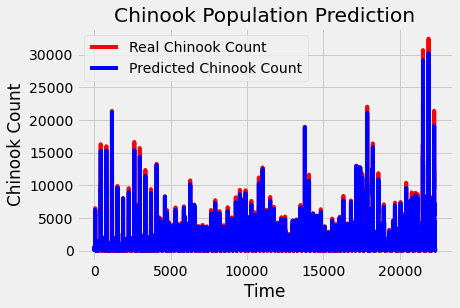

The root mean squared error is 523.9613938844387.


In [28]:
plot_predictions(y_train, GRU_train_day)
return_rmse(y_train, GRU_train_day)

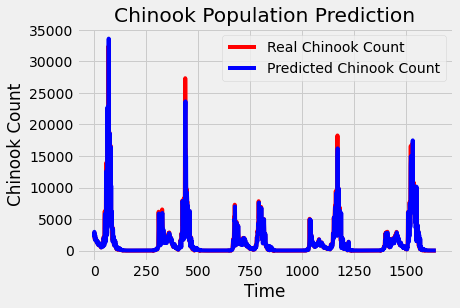

The root mean squared error is 1407.1298130688763.


In [29]:
plot_predictions(y_test, GRU_test_day)
return_rmse(y_test, GRU_test_day)

dict_keys(['loss'])


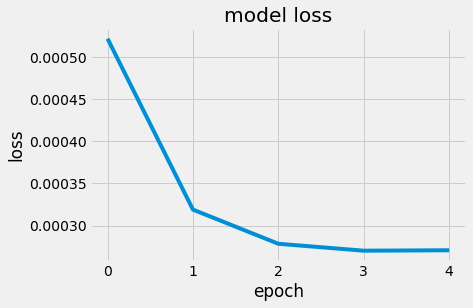

In [30]:
print(history_GRU.history.keys())
plt.plot(history_GRU.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [67]:
def day_to_year(day_preds):
    day_preds = day_preds[183:]
    year_preds = []
    for i in range(365, len(day_preds), 365):   
        salmon_count = np.sum(day_preds[i - 365:i])
        year_preds.append(salmon_count)
    year_preds = pd.DataFrame(year_preds, columns = ["Count"])
    return year_preds

In [68]:
GRU_test_year = day_to_year(GRU_test_day)
y_test_year = day_to_year(y_test)
GRU_test_year

,Count
0,529695
1,411789
2,447101
3,566929


In [78]:
bs_chris_path = '/Users/chrisshell/Desktop/Stanford/SalmonData/Forecast Data Update.csv'
bs_ismael_path = ''
bs_abdul_path = ''
baseline_data = pd.read_csv(bs_chris_path)
traditional = pd.DataFrame(baseline_data["Count"])
print(traditional)
y_test_year = y_test_year.astype(np.int64)
print(y_test_year)
print(GRU_test_year)
return_rmse(y_test_year, traditional)
return_rmse(y_test_year, GRU_test_year)

    Count
0  498710
1  439060
2  294840
3  347600
    Count
0  488981
1  336030
2  381774
3  535748
    Count
0  529695
1  411789
2  447101
3  566929
The root mean squared error is 115830.72196205116.
The root mean squared error is 56207.04485871855.


In [25]:
# test basic single layer RNN
model, test_preds = create_single_layer_rnn_model(x_train, y_train, x_test, king_training)

NameError: name 'king_training' is not defined

In [26]:
plot_predictions(y_test, test_preds)
print(test_preds.shape)

NameError: name 'test_preds' is not defined

In [34]:
# running LSTM
LSTM_model, test_preds_LSTM, train_preds_LSTM, y_test, y_train, history_LSTM = create_LSTM_model(x_train, y_train, x_test, y_test)

Epoch 1/25
150/150 - 6s - loss: 0.0012
Epoch 2/25
150/150 - 5s - loss: 6.1279e-04
Epoch 3/25
150/150 - 5s - loss: 5.0729e-04
Epoch 4/25
150/150 - 4s - loss: 4.5545e-04
Epoch 5/25
150/150 - 4s - loss: 4.2017e-04
Epoch 6/25
150/150 - 4s - loss: 3.9350e-04
Epoch 7/25
150/150 - 4s - loss: 3.6843e-04
Epoch 8/25
150/150 - 4s - loss: 3.4453e-04
Epoch 9/25
150/150 - 5s - loss: 3.2686e-04
Epoch 10/25
150/150 - 5s - loss: 3.1293e-04
Epoch 11/25
150/150 - 5s - loss: 2.9904e-04
Epoch 12/25
150/150 - 4s - loss: 2.8892e-04
Epoch 13/25
150/150 - 4s - loss: 2.8133e-04
Epoch 14/25
150/150 - 4s - loss: 2.7714e-04
Epoch 15/25
150/150 - 5s - loss: 2.7161e-04
Epoch 16/25
150/150 - 5s - loss: 2.7129e-04
Epoch 17/25
150/150 - 5s - loss: 2.6661e-04
Epoch 18/25
150/150 - 4s - loss: 2.6472e-04
Epoch 19/25
150/150 - 4s - loss: 2.6337e-04
Epoch 20/25
150/150 - 5s - loss: 2.6299e-04
Epoch 21/25
150/150 - 4s - loss: 2.6181e-04
Epoch 22/25
150/150 - 4s - loss: 2.6301e-04
Epoch 23/25
150/150 - 4s - loss: 2.6306e-04
E

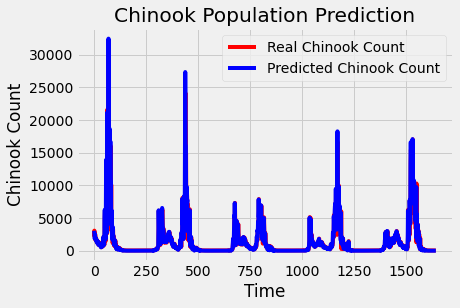

In [35]:
plot_predictions(test_preds_LSTM, y_test)

In [36]:
return_rmse(y_test, test_preds_LSTM)

The root mean squared error is 1377.5061269319676.


In [37]:
print(history_LSTM.history.keys())

dict_keys(['loss'])


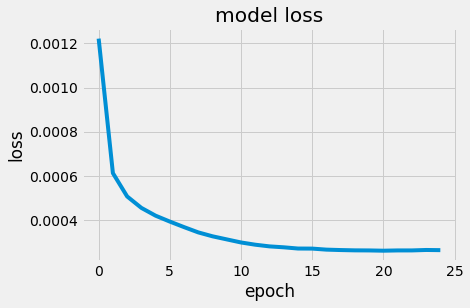

In [38]:
plt.plot(history_LSTM.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [60]:
# Comparing RMSE to curr Forecasting methods to LSTM
LSTM_test_year = day_to_year(test_preds_LSTM)